In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# 1. Data

In [115]:
df_train = pd.read_csv('train.csv')
df_submission = pd.read_csv('test.csv')

In [116]:
print(f"Training data set shape: {df_train.shape}, test dataset shape {df_submission.shape}")

Training data set shape: (891, 12), test dataset shape (418, 11)


In [117]:
df_train.head(5).T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [118]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [119]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Let's fill NA with values:

In [120]:
df_train.Age.fillna(df_train.Age.median(), inplace=True)
df_submission.Age.fillna(df_submission.Age.median(), inplace=True)
df_train.Cabin.fillna('XX_unknown', inplace=True)
df_submission.Cabin.fillna('XX_unknown', inplace=True)
df_train.Embarked.fillna(df_train.Embarked.mode()[0], inplace=True)
df_submission.Embarked.fillna(df_submission.Embarked.mode()[0], inplace=True)
df_submission.Fare.fillna(df_submission.Fare.median(), inplace=True)

In [121]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### Some features, visualize, drop unused cols, etc.

In [122]:
df_train['Name_length'] = df_train.Name.str.len()
df_submission['Name_length'] = df_submission.Name.str.len()
df_train['Cabin_letter'] = df_train.Cabin.str[0]
df_submission['Cabin_letter'] = df_submission.Cabin.str[0]

In [123]:
df_train.drop('Ticket', axis=1, inplace=True)
df_submission.drop('Ticket', axis=1, inplace=True)
df_train.drop('PassengerId', axis=1, inplace=True)
#df_submission.drop('PassengerId', axis=1, inplace=True)
df_train.drop('Name', axis=1, inplace=True)
df_submission.drop('Name', axis=1, inplace=True)
df_train.drop('Cabin', axis=1, inplace=True)
df_submission.drop('Cabin', axis=1, inplace=True)

In [124]:
df_train.head(5).T

,0,1,2,3,4
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Fare,7.25,71.2833,7.925,53.1,8.05
Embarked,S,C,S,S,S
Name_length,23,51,22,44,24
Cabin_letter,X,C,X,C,X


In [125]:
df_train_label_enc = df_train.copy()
df_sub_label_enc = df_submission.copy()
labelencoder = LabelEncoder()
df_train_label_enc.Sex = labelencoder.fit_transform(df_train_label_enc.Sex)
df_train_label_enc.Embarked = labelencoder.fit_transform(df_train_label_enc.Embarked)
df_train_label_enc.Cabin_letter = labelencoder.fit_transform(df_train_label_enc.Cabin_letter)
df_sub_label_enc.Sex = labelencoder.fit_transform(df_sub_label_enc.Sex)
df_sub_label_enc.Embarked = labelencoder.fit_transform(df_sub_label_enc.Embarked)
df_sub_label_enc.Cabin_letter = labelencoder.fit_transform(df_sub_label_enc.Cabin_letter)

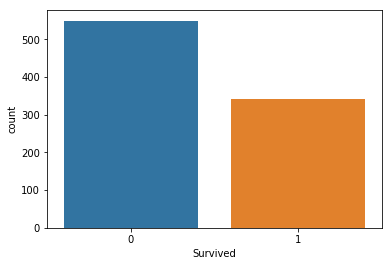

In [126]:
sns.countplot(data=df_train_label_enc, x='Survived')

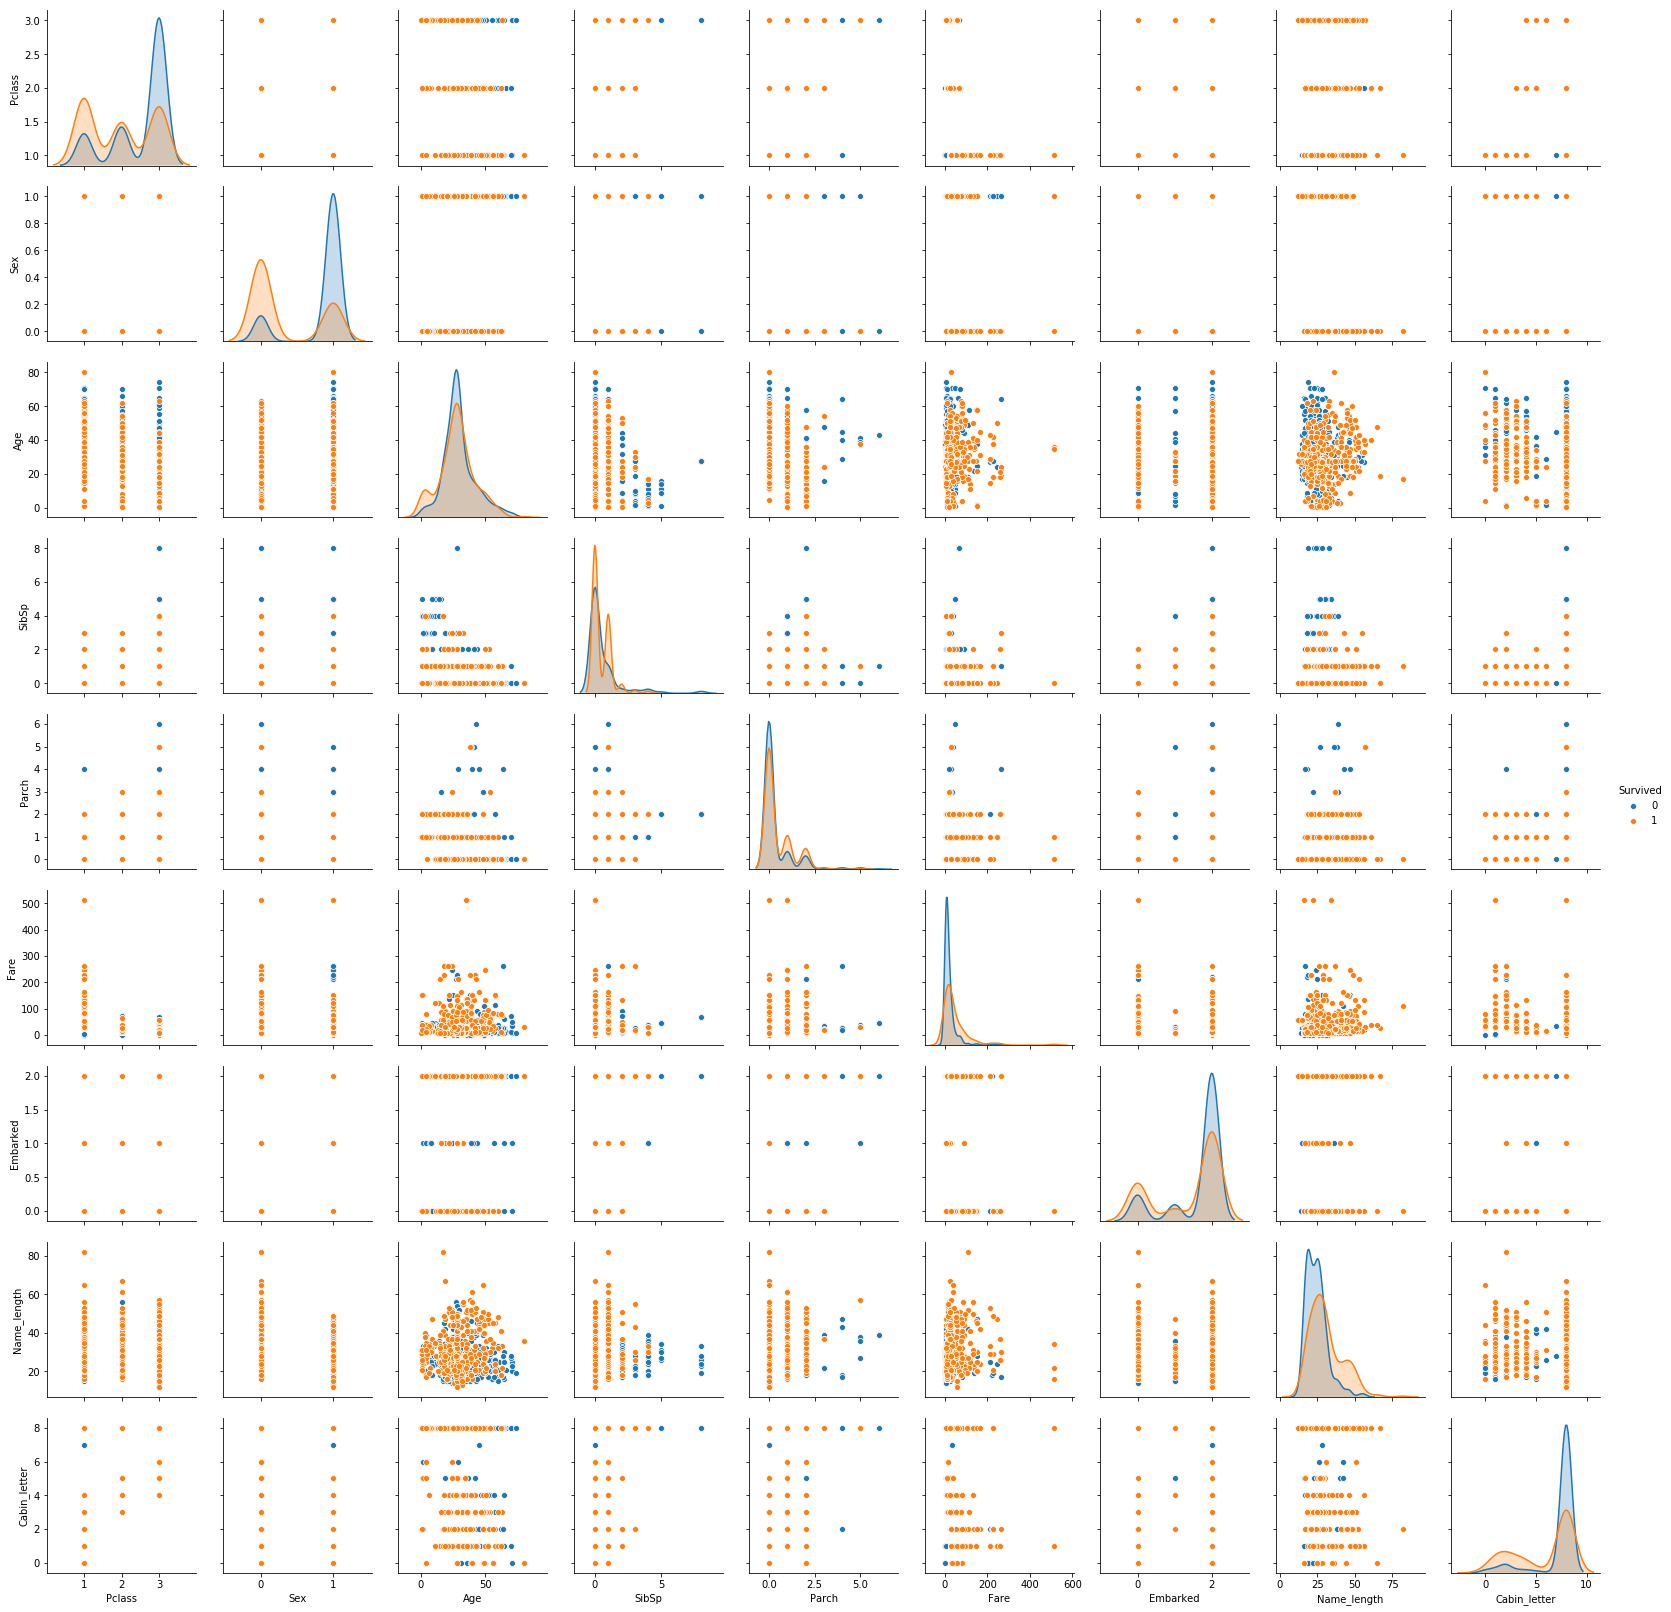

In [127]:
feature_columns = df_train_label_enc.columns.tolist()
feature_columns.remove('Survived')
sns.pairplot(df_train_label_enc, hue='Survived', vars=feature_columns)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

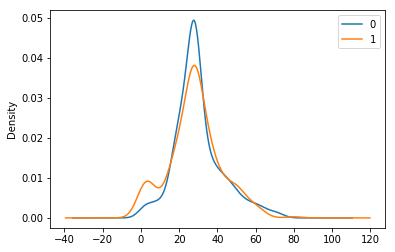

In [128]:
df_train_label_enc.groupby('Survived').Age.plot(kind='kde', legend=True)

In [129]:
train_data_enc, test_data_enc, train_labels_enc, test_labels_enc = train_test_split(
    df_train_label_enc.drop('Survived', axis=1, inplace=False), 
    df_train_label_enc.Survived, 
    test_size=0.25)

### RF as a benchmark 

In [130]:
rfc = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions={
        'n_estimators': np.arange(100, 200, 20),
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': np.arange(1, 20),
        'max_depth': np.arange(1, 15),
    },
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=1,
)

In [131]:
rfc.fit(train_data_enc, train_labels_enc)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [132]:
rfc.best_params_

{'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'n_estimators': 180}

In [133]:
rfc.best_score_

0.8338323353293413

In [134]:
rfc_test_enc_preds = rfc.predict(test_data_enc)

In [135]:
print(confusion_matrix(test_labels_enc, rfc_test_enc_preds))

[[127  10]
 [ 29  57]]


In [136]:
print(classification_report(test_labels_enc, rfc_test_enc_preds))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       137
           1       0.85      0.66      0.75        86

    accuracy                           0.83       223
   macro avg       0.83      0.79      0.81       223
weighted avg       0.83      0.83      0.82       223



The RF score on the board was 0.77.

## NN with one-hot 

In [137]:
vars_for_dummies = [
    'Sex',
    'Embarked',
    'Cabin_letter',
]

In [138]:
df_train_one_hot = pd.get_dummies(
    df_train, prefix=vars_for_dummies, columns=vars_for_dummies, drop_first=True)
df_submission_one_hot = pd.get_dummies(
    df_submission, prefix=vars_for_dummies, columns=vars_for_dummies, drop_first=True)

In [139]:
df_train_one_hot.shape

(891, 18)

In [140]:
df_submission_one_hot.shape

(418, 17)

In [141]:
df_train_one_hot.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name_length',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Cabin_letter_B',
       'Cabin_letter_C', 'Cabin_letter_D', 'Cabin_letter_E', 'Cabin_letter_F',
       'Cabin_letter_G', 'Cabin_letter_T', 'Cabin_letter_X'],
      dtype='object')

In [142]:
df_submission_one_hot.columns

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name_length',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Cabin_letter_B',
       'Cabin_letter_C', 'Cabin_letter_D', 'Cabin_letter_E', 'Cabin_letter_F',
       'Cabin_letter_G', 'Cabin_letter_X'],
      dtype='object')

In [144]:
df_train_one_hot.drop('Cabin_letter_T', axis=1, inplace=True)

In [145]:
train_data_one_hot, val_data_one_hot, train_labels_one_hot, val_labels_one_hot = train_test_split(
    df_train_one_hot.drop('Survived', axis=1, inplace=False), 
    df_train_one_hot.Survived, 
    test_size=0.25)

In [146]:
def make_classifier(n_layers, layer_size, n_classes, final_activation, input_shape):
    layers = [tf.keras.layers.BatchNormalization(input_shape=input_shape)]
    for _ in range(n_layers):
        layers.extend([
                tf.keras.layers.Dense(layer_size, kernel_initializer='he_uniform'),
                tf.keras.layers.LeakyReLU(), 
                tf.keras.layers.BatchNormalization(),
            ])
    layers.append(tf.keras.layers.Dense(n_classes, activation=final_activation))
    return tf.keras.Sequential(layers)

In [157]:
dnnc1 = make_classifier(1, 32, 1, 'sigmoid', train_data_one_hot.values.shape[1:])
dnnc2 = make_classifier(3, 32, 1, 'sigmoid', train_data_one_hot.shape[1:])

In [158]:
LR = 3e-3
N_EPOCHS = 40
BATCH_SIZE = 32

In [159]:
dnnc1.compile(
    optimizer=tf.keras.optimizers.Adam(lr=LR),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
    ]
)

In [160]:
dnnc2.compile(
    optimizer=tf.keras.optimizers.Adam(lr=LR),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
    ]
)

In [161]:
dnnc1.fit(
    x=train_data_one_hot.values,
    y=train_labels_one_hot.values,
    validation_data=(val_data_one_hot.values, val_labels_one_hot.values),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    shuffle=True,
)

Train on 668 samples, validate on 223 samples
Epoch 1/40
668/668 [==============================] - 1s 2ms/sample - loss: 0.7623 - binary_accuracy: 0.5689 - val_loss: 0.6902 - val_binary_accuracy: 0.6413
Epoch 2/40
668/668 [==============================] - 0s 217us/sample - loss: 0.5234 - binary_accuracy: 0.7455 - val_loss: 0.5655 - val_binary_accuracy: 0.6861
Epoch 3/40
668/668 [==============================] - 0s 190us/sample - loss: 0.4773 - binary_accuracy: 0.7844 - val_loss: 0.6087 - val_binary_accuracy: 0.6502
Epoch 4/40
668/668 [==============================] - 0s 192us/sample - loss: 0.4503 - binary_accuracy: 0.7994 - val_loss: 0.6062 - val_binary_accuracy: 0.6502
Epoch 5/40
668/668 [==============================] - 0s 217us/sample - loss: 0.4383 - binary_accuracy: 0.8084 - val_loss: 0.5934 - val_binary_accuracy: 0.6547
Epoch 6/40
668/668 [==============================] - 0s 154us/sample - loss: 0.4381 - binary_accuracy: 0.8054 - val_loss: 0.5866 - val_binary_accuracy: 0.6

In [162]:
dnnc2.fit(
    x=train_data_one_hot.values,
    y=train_labels_one_hot.values,
    validation_data=(val_data_one_hot.values, val_labels_one_hot.values),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    shuffle=True,
)

Train on 668 samples, validate on 223 samples
Epoch 1/40
668/668 [==============================] - 2s 3ms/sample - loss: 0.5942 - binary_accuracy: 0.7006 - val_loss: 0.5908 - val_binary_accuracy: 0.7578
Epoch 2/40
668/668 [==============================] - 0s 208us/sample - loss: 0.4647 - binary_accuracy: 0.7904 - val_loss: 0.5389 - val_binary_accuracy: 0.7220
Epoch 3/40
668/668 [==============================] - 0s 207us/sample - loss: 0.4443 - binary_accuracy: 0.8129 - val_loss: 0.6349 - val_binary_accuracy: 0.6547
Epoch 4/40
668/668 [==============================] - 0s 131us/sample - loss: 0.4335 - binary_accuracy: 0.8174 - val_loss: 0.6304 - val_binary_accuracy: 0.6547
Epoch 5/40
668/668 [==============================] - 0s 133us/sample - loss: 0.4113 - binary_accuracy: 0.8144 - val_loss: 0.6326 - val_binary_accuracy: 0.6457
Epoch 6/40
668/668 [==============================] - 0s 130us/sample - loss: 0.3942 - binary_accuracy: 0.8249 - val_loss: 0.6102 - val_binary_accuracy: 0.6

# Submission

In [166]:
def prepare_submission(preds):
    submission = pd.DataFrame()
    submission['PassengerId'] = df_submission.PassengerId
    submission['Survived'] = preds
    return submission

In [167]:
rfc_sub = prepare_submission(rfc.predict(df_sub_label_enc.drop('PassengerId', axis=1)))
dnnc1_sub = prepare_submission((dnnc1.predict(df_submission_one_hot.drop('PassengerId', axis=1)) > 0.5).astype(int))
dnnc2_sub = prepare_submission((dnnc2.predict(df_submission_one_hot.drop('PassengerId', axis=1)) > 0.5).astype(int))

In [168]:
rfc_sub.to_csv('rfc.csv', index=False)
dnnc1_sub.to_csv('dnnc1.csv', index=False)
dnnc2_sub.to_csv('dnnc2.csv', index=False)

The RF score on the board was 0.77. Both NN models scored 0.75 - 0.76.